In [2]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Step 1: Define Dataset and DataLoader
data_dir = "/kaggle/input/iam-handwritten-forms-dataset/data"  # Update this to your dataset path

In [4]:
# Transformations: Resize, Normalize
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to fixed size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

In [5]:
# Load Dataset
dataset = ImageFolder(root=data_dir, transform=transform)

In [6]:
# Split Dataset: Train/Validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [8]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # Adjust output layer

    def forward(self, x):
        return self.model(x)

In [10]:
# Number of classes (writers)
num_classes = len(dataset.classes)

In [11]:
# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_classes=num_classes).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s] 


In [14]:
# Step 3: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Step 4: Train the Model
train_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Validation Accuracy
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    val_accuracies.append(100 * correct_val / total_val)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracies[-1]:.2f}%, Validation Accuracy: {val_accuracies[-1]:.2f}%")

Epoch [1/25], Loss: 6.7909, Train Accuracy: 4.71%, Validation Accuracy: 1.95%
Epoch [2/25], Loss: 5.3325, Train Accuracy: 8.04%, Validation Accuracy: 6.17%
Epoch [3/25], Loss: 4.3971, Train Accuracy: 17.63%, Validation Accuracy: 12.01%
Epoch [4/25], Loss: 3.4130, Train Accuracy: 30.63%, Validation Accuracy: 12.99%
Epoch [5/25], Loss: 2.5622, Train Accuracy: 44.03%, Validation Accuracy: 16.23%
Epoch [6/25], Loss: 1.7852, Train Accuracy: 59.14%, Validation Accuracy: 18.83%
Epoch [7/25], Loss: 1.1715, Train Accuracy: 71.73%, Validation Accuracy: 18.83%
Epoch [8/25], Loss: 0.7459, Train Accuracy: 84.81%, Validation Accuracy: 33.44%
Epoch [9/25], Loss: 0.4936, Train Accuracy: 90.33%, Validation Accuracy: 40.91%
Epoch [10/25], Loss: 0.3273, Train Accuracy: 93.99%, Validation Accuracy: 38.96%
Epoch [11/25], Loss: 0.2631, Train Accuracy: 94.96%, Validation Accuracy: 47.40%
Epoch [12/25], Loss: 0.1777, Train Accuracy: 96.83%, Validation Accuracy: 41.56%
Epoch [13/25], Loss: 0.1115, Train Accura

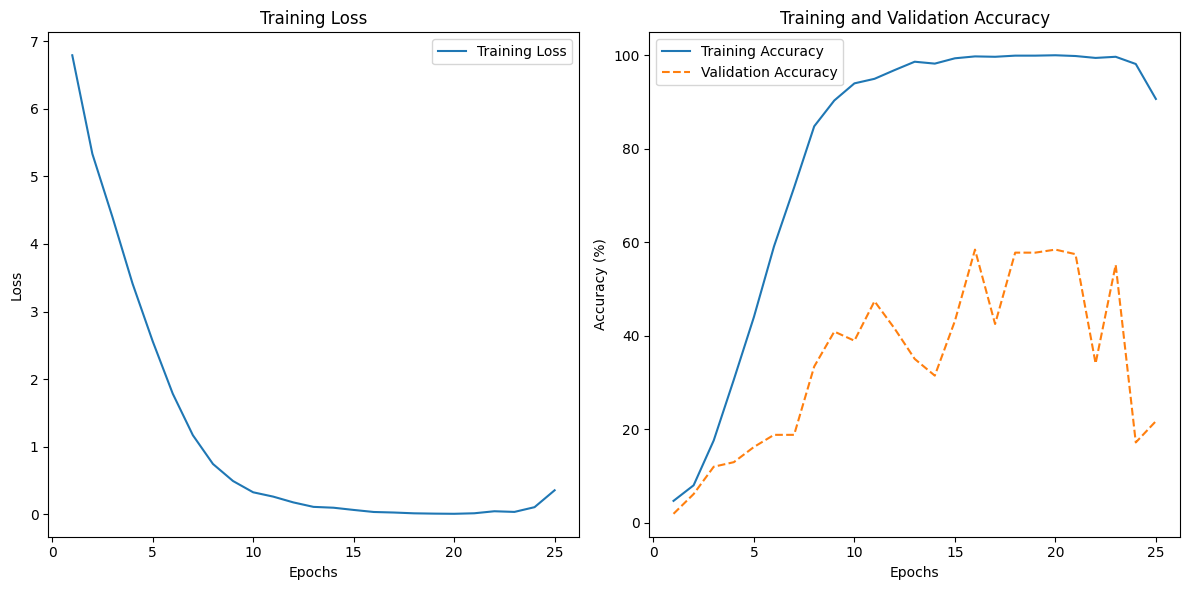

In [16]:
# Step 5: Plot Training and Validation Metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# Split Dataset: Train/Test
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train, test = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [18]:
# DataLoader
train_load = DataLoader(train, batch_size=32, shuffle=True)
test_load = DataLoader(test, batch_size=32, shuffle=False)

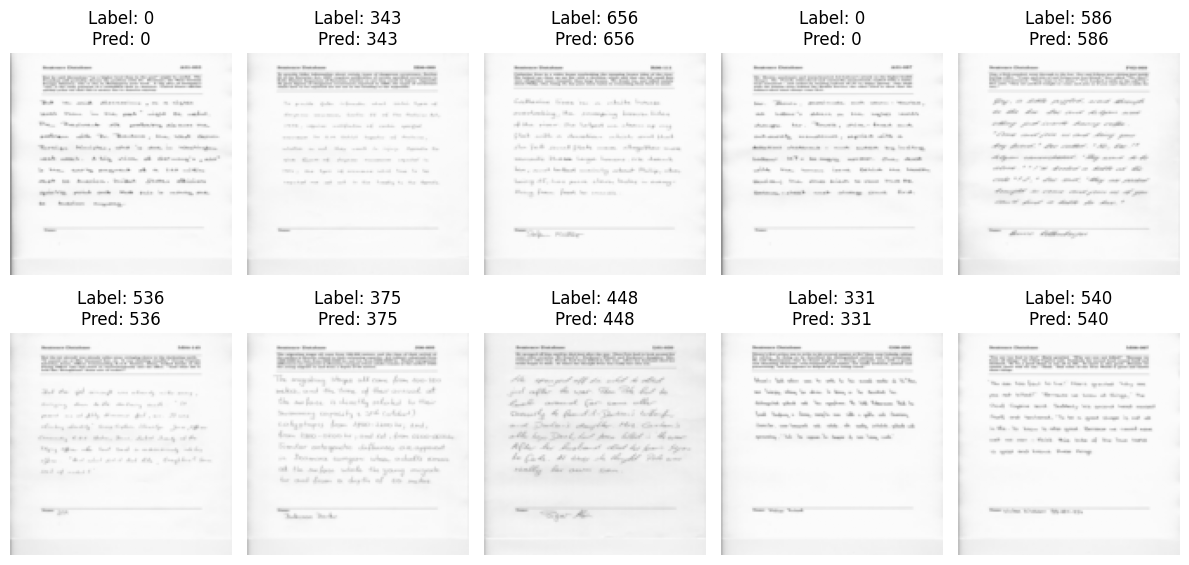

In [19]:
# Visualize correct predictions
model.eval()
correct_images, correct_labels, predicted_labels = [], [], []

with torch.no_grad():
    for images, labels in test_load:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        mask = (predicted == labels)
        correct_images.extend(images[mask].cpu())
        correct_labels.extend(labels[mask].cpu())
        predicted_labels.extend(predicted[mask].cpu())
        if len(correct_images) >= 10:  # Display 10 correct images
            break

# Visualize correct predictions
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = correct_images[i].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
    img = img * 0.5 + 0.5  # Denormalize
    plt.imshow(img.numpy())
    plt.title(f"Label: {correct_labels[i].item()}\nPred: {predicted_labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()